## 1. 檢查 GPU
首先確定我們可以使用 GPU。我們可以使用 nvidia-smi 命令來檢查。如果出現錯誤訊息，請前往「編輯」->「筆記本設定」->「硬體加速器」，將其設置為 GPU，然後點擊保存。

In [ ]:
!nvidia-smi

Fri May 10 15:05:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 2. YOLOv8
YOLOv8 模型是由 Ultralytics 公司基於 YOLOv5 和 YOLOv7 模型進行開發的，繼承了這兩個版本的優點，同時做出了一系列改進，以提供更高效和準確的物件偵測能力。YOLOv8 已經在 coco 數據集上訓練過，該數據集包含 80 個可預測的類別。我們將獲取這些預訓練權重，以便可以在這些預訓練類別上運行物件辨識。您可以從以下連結查看預訓練的 YOLOv8 權重可以檢測到哪些類別。

- [COCO CLASSES](http://cocodataset.org/#explore)

### 2.1 安裝 ultralytics
Ultralytics HUB提供了廣泛的YOLO系列模型訓練平台，讓用戶可以輕鬆地訓練多種不同版本的YOLO（You Only Look Once）物件偵測模型。此平台不僅提供了豐富的訓練資源，還提供預訓練模型，使得用戶能夠更快速地開始物件偵測任務，大幅縮短了模型開發和部署的時間。

In [2]:
!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.8/78.2 GB disk)


### 2.2 使用 CLI 指令預測(方法一)
ultralytics 內建提供命令列介面(CLI) 可以直接透過指令下載 Yolov8 權重，並讀取影像直接推論並輸出結果影像。

In [3]:
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 6.23M/6.23M [00:00<00:00, 71.9MB/s]
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

100% 104k/104k [00:00<00:00, 43.5MB/s]
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 177.9ms
Speed: 16.5ms preprocess, 177.9ms inference, 1413.6ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


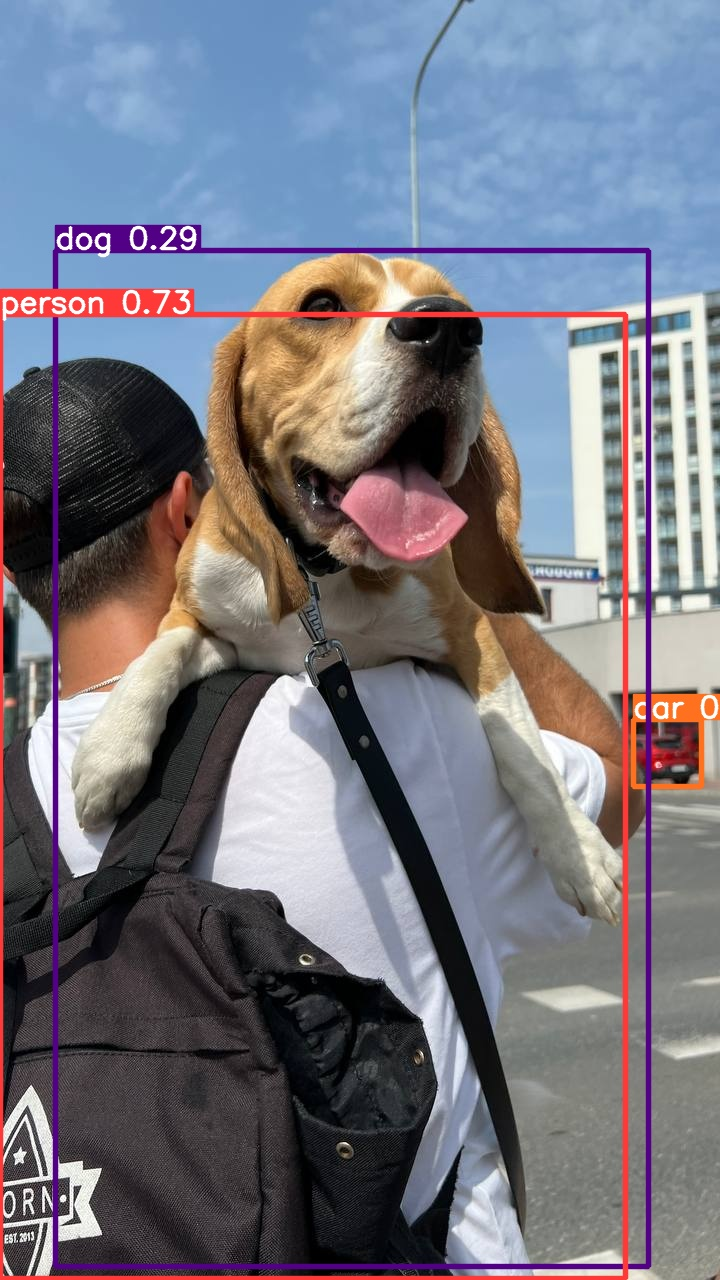

In [6]:
from PIL import Image

# 顯示預測結果
Image.open('runs/detect/predict/dog.jpeg')

### 2.3 使用 Python API 預測 方法二
我們可以使用 Ultralytics 的 YOLO 模組進行物件偵測。並透過內建的 Annotator 將預測結果的物件框視覺化輸出。


Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 16.1ms
Speed: 8.3ms preprocess, 16.1ms inference, 9.4ms postprocess per image at shape (1, 3, 640, 384)


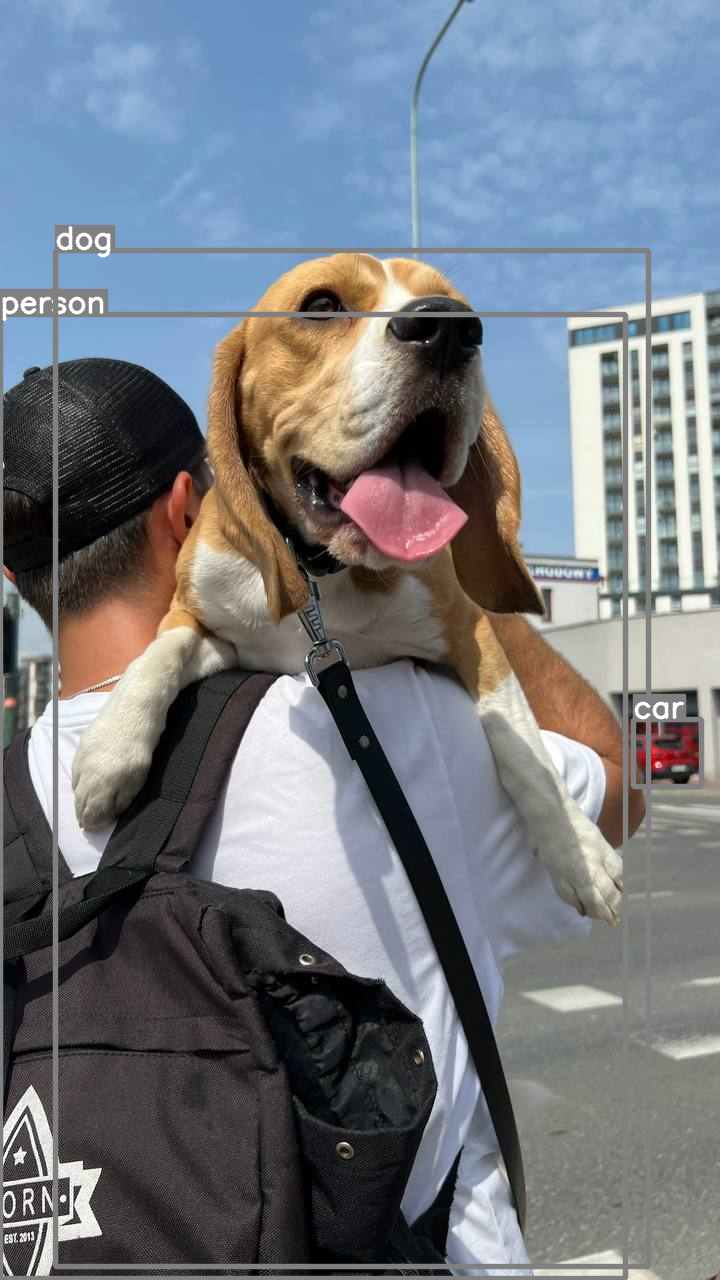

In [8]:
from ultralytics import YOLO
from PIL import Image
from ultralytics.utils.plotting import Annotator

# 載入預訓練的 YOLOv8 模型
model = YOLO('yolov8n.pt')

# 使用模型預測結果
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)

# 遍歷預測結果，繪製邊界框和標籤
for r in results:
    img = results[0].orig_img
    annotator = Annotator(img)
    boxes = r.boxes  # 獲取物件框的資訊
    for box in boxes:
        b = box.xyxy[0]  # 獲取邊界框坐標 (left, top, right, bottom) 格式
        c = box.cls # 取得預測類別
        annotator.box_label(b, model.names[int(c)])

# 顯示預測結果
Image.fromarray(img[:,:,::-1], 'RGB')

### 2.4 使用 Python API 預測 方法三
我們也可以提取 ultralytics 預測出來的結果，並透過 OpenCV 手動繪製預測的物件框與信心分數。

In [11]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)

# 從預測結果中提取類別、信心分數、邊界框和類別名稱
classes = results[0].boxes.cls.cpu().numpy().astype('int')  # 獲取預測類別
scores = results[0].boxes.conf.cpu().numpy()  # 獲取預測信心分數
boxes = results[0].boxes.xyxy.cpu().numpy().astype('int')  # 獲取邊界框坐標 (left, top, right, bottom) 格式
class_names = list(results[0].names.values())  # 提取所有類別名稱
img = results[0].orig_img  # 獲取原始圖片


Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)


In [10]:
# 建立顏色列表
class Colors:
    # Ultralytics color palette https://ultralytics.com/
    def __init__(self):
        hexs = ('FF3838', 'FF9D97', 'FF701F', 'FFB21D', 'CFD231', '48F90A', '92CC17', '3DDB86', '1A9334', '00D4BB',
                '2C99A8', '00C2FF', '344593', '6473FF', '0018EC', '8438FF', '520085', 'CB38FF', 'FF95C8', 'FF37C7')
        self.palette = [self.hex2rgb(f'#{c}') for c in hexs]
        self.n = len(self.palette)

    def __call__(self, i, bgr=False):
        c = self.palette[int(i) % self.n]
        return (c[2], c[1], c[0]) if bgr else c

    @staticmethod
    def hex2rgb(h):  # rgb order (PIL)
        return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
colors = Colors()

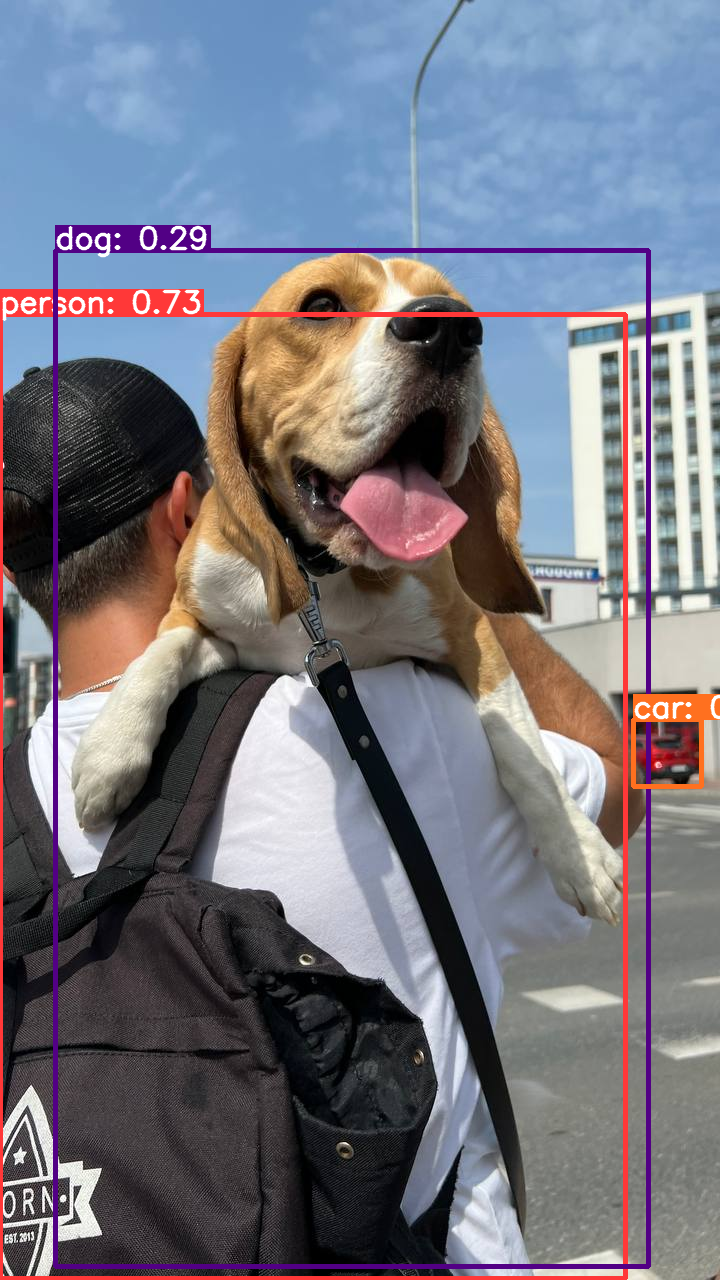

In [ ]:
from PIL import Image
import colorsys
import cv2


# num_classes = len(class_names)
image_h, image_w, _ = img.shape

# 確保有偵測結果
if len(classes) > 0:
    for (classid, score, box) in zip(classes, scores, boxes):
        # 取得方框座標和類別
        x, y, x2, y2 = box
        # 取得顏色
        bbox_color = colors(classid, True)
        bbox_thick = int(0.6 * (image_h + image_w) / 300)
        # 繪製方框
        cv2.rectangle(img, (x, y), (x2, y2), bbox_color, bbox_thick)

        # 在方框上方添加文字
        label = f"{class_names[classid]}: {score:.2f}"
        t_size = cv2.getTextSize(label, 0, 1, thickness=bbox_thick // 2)[0]
        c3 = (x + t_size[0], y - t_size[1] - 3)
        cv2.rectangle(img, (x, y), (int(c3[0]), int(c3[1])), bbox_color, -1) #filled
        cv2.putText(img, label, (x, y - 2), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), bbox_thick // 2, lineType=cv2.LINE_AA)

# 顯示預測結果
Image.fromarray(img[:,:,::-1], 'RGB')